### Load the Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import RBFInterpolator
from plotly.subplots import make_subplots
from matplotlib.colors import PowerNorm
warnings.filterwarnings('ignore')

### Import the Tree Transect to be Processed

In [2]:
# read file
transect1 = np.genfromtxt("data/Tree4_6x6_migrated/Migrated_04840.ASC", dtype=None)
transect1

array([[  150,   153,    66, ...,   148,   232,   283],
       [ -180,  -220,  -279, ...,  -392,  -431,  -484],
       [ -731,  -828,  -845, ..., -1333, -1596, -1835],
       ...,
       [ 1667,  1584,  1673, ..., -2147, -1701, -1806],
       [  170,   455,   338, ..., -3683, -2016, -2337],
       [ -679,    22,  -211, ..., -4888, -2316, -2784]])

#### Normalize the data to range [-1, 1]

In [3]:
scaler = MinMaxScaler(feature_range=(-1, 1))
normalised_data = scaler.fit_transform(transect1)

##### Slicing through the column of the array which is equivalent to the number of depth

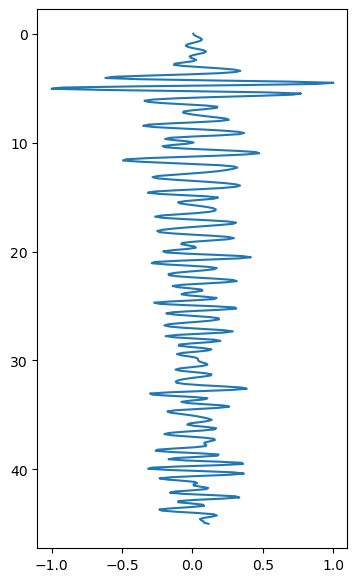

In [4]:
digitized_points = transect1.shape[0]

plt.figure(figsize=(4, 7))
plt.plot(normalised_data[:, 23], np.linspace(0, 45, digitized_points))

ax = plt.gca()
ax.invert_yaxis()

### Functions that creates the cylindrical dataset in cartesian coordinate

In [5]:

# Creating a function that creates the X, Y coordinates from 
# a given radius and the number of columns or traces

def create_CardPoints(rad, trace_num):
    """Create 1 2D array with with shape (trace_num x 2).
    
    parameters:
    ----------
    rad: radius from the center of the trunk in centimeters.
    
    Returns:
    ρ, θ, X, and Y
    """
    dist = trace_num * 0.02  # The distance of the horizontal profile
    
    arr = np.ones((trace_num, 4))
    arr[:, 0] = rad/100  # converting the radius to meters since the distance is in meters
    arr[:, 1] = np.linspace(0.02, dist, trace_num) / (arr[:, 0])
    # θ = distance / radius
    arr[:, 2] = arr[:, 0] * np.cos(arr[:, 1])
    arr[:, 3] = arr[:, 0] * np.sin(arr[:, 1])
    
    return arr   

def createZ(sample_pts, depth = 'time', velocity=0.1):
    """Convert the number of digitized points into depth profile.
    
    The vertical axis can be converted to depth in time or depth by
    spreading out the numbers of digitized points across the 45.45 ns
    the EM waves were collected.
    """
    
    if depth == 'time':
        calc_depth = np.linspace(0, 45.45, sample_pts)  # Depth in time
        return calc_depth
        
    # To convert to distance, distance = velocity * time *.5
    # the velocity was discovered to vary between 0.1 - 0.15 ns
    
    return np.linspace(0, 45.45, sample_pts) * .5 * velocity  
        
    

### Creating the X and Y values, and the amplitude for all the transects collected around a tree.

Because we have to append to the list. We have to create the data for the first transect and add the other transects to the array created.

#### #1: Creating the points for the first transects

In [6]:
# starting radius
radius = 48.4 

transect1 = np.genfromtxt("data/Tree4_6x6_migrated/Migrated_04840.ASC", dtype=None)
amp_array1 = scaler.fit_transform(transect1)

# creating an array that stores the X and Y coordinate for all the transects
coord_array1 = create_CardPoints(radius, transect1.shape[1])
depth_z1 = createZ(transect1.shape[0], depth='dist')  
# transect1.shape[0] is the sample point, that is the number of digitized points

#### #2: Visualization in 2D

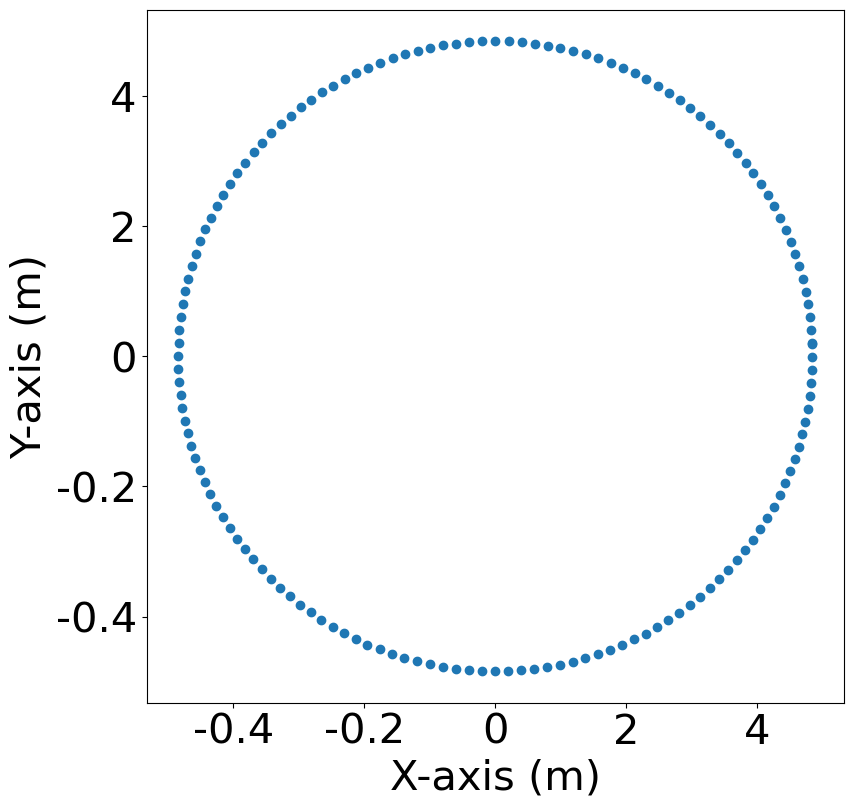

In [7]:
fig = plt.figure(figsize=(9,9), dpi=100)
ax = plt.subplot(111)

# The variables are
X = coord_array1[:, 2]
Y = coord_array1[:, 3]
ax.scatter(X, Y)
ax.set_xlabel('X-axis (m)',size=30)
ax.set_ylabel('Y-axis (m)',size=30)
lab = [-.6, -.4, -.2, 0, 2, 4, 6]
ax.set_xticklabels(lab, fontsize=30)
ax.set_yticklabels(lab, fontsize=30)

plt.show()

#### #3: Visualization in 3D

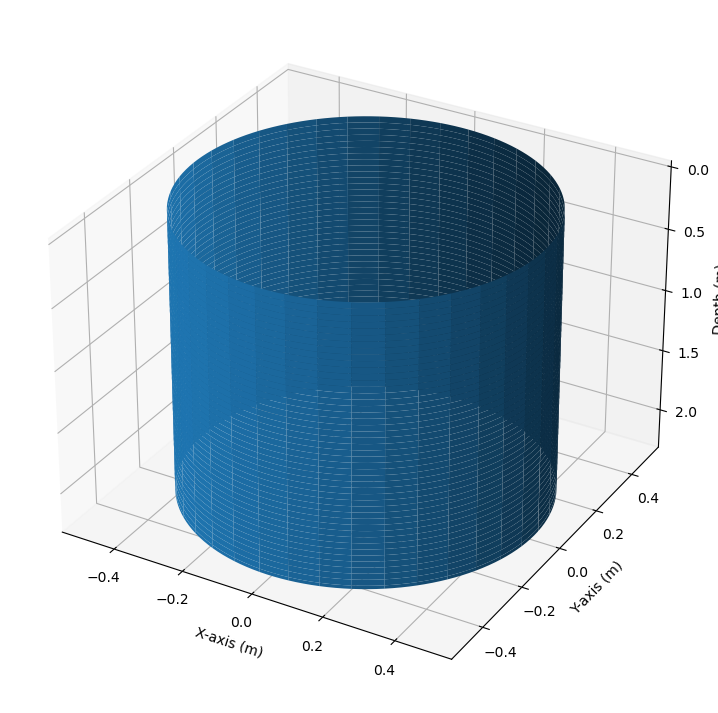

In [8]:
fig = plt.figure(figsize=(11,9), dpi=100)
ax = plt.subplot(111, projection='3d')

# The variables are
X = coord_array1[:, 2]
Y = coord_array1[:, 3]
Z = depth_z1.reshape(-1, 1)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('X-axis (m)')
ax.set_ylabel('Y-axis (m)')
ax.set_zlabel('Depth (m)')

ax.invert_zaxis()

plt.show()

#### #4: Appending all other transects to the first transects

In [9]:
list_dir = os.listdir('data/Tree4_6x6_migrated')  # a list of the tree's transects
list_dir = sorted(list_dir)  # Added sorted to the list

# copy the amplitude and coordinate array for the first transect
amp_array = amp_array1.copy()
coord_array = coord_array1.copy()

# starting radius of the second transect
radius = 58.4 

for index, transect in enumerate(list_dir[1:]):
    selected_trans = np.genfromtxt(f"data/Tree4_6x6_migrated/{transect}", dtype=None)
    
    # store the individual file amplitude in the dictionary
    # Normalized the amplitude to be between -1 and 1
    amp_array = np.hstack((amp_array, scaler.fit_transform(selected_trans)))  # fixed column
    coord_array = np.vstack((coord_array, create_CardPoints(radius, selected_trans.shape[1])))
    
    radius += 10  # incrementing 10 cm increase for each transect.

# Transpose the amp_arr
amp_array = amp_array.T

#### #5: Plotting the top view of the transects

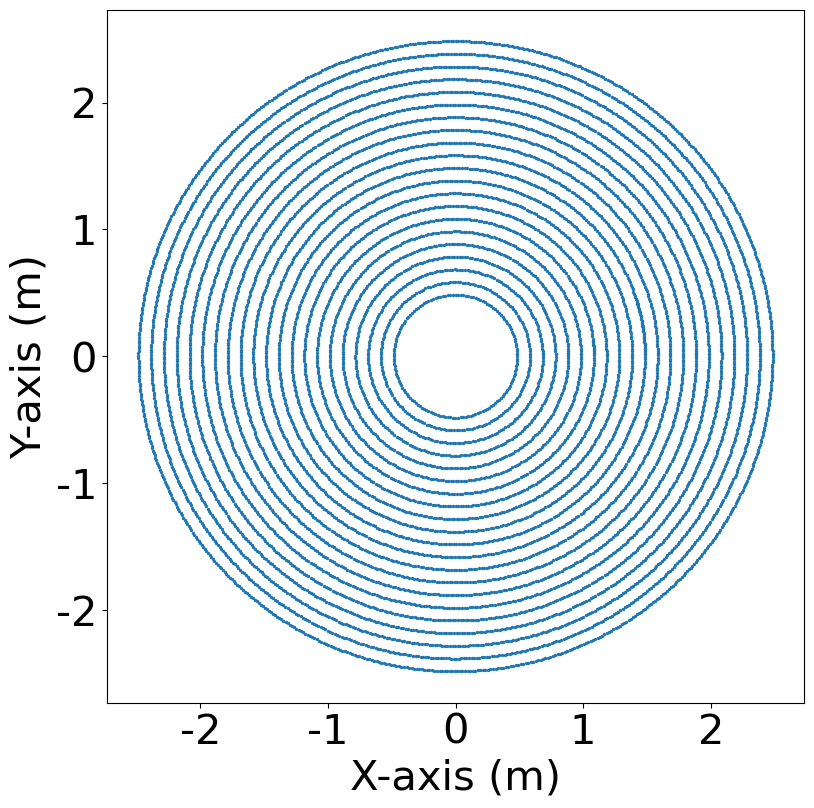

In [11]:
fig = plt.figure(figsize=(9,9), dpi=100)
ax = plt.subplot(111)

# The variables are
X = coord_array[:, 2]
Y = coord_array[:, 3]
ax.scatter(X, Y, s=2)
ax.set_xlabel('X-axis (m)',size=30)
ax.set_ylabel('Y-axis (m)',size=30)
lab = np.arange(-3, 3)
ax.set_xticklabels(lab, fontsize=30)
ax.set_yticklabels(lab, fontsize=30)
plt.show()

### Creating a Mesh that allocates the amplitude value to an xi, yi, and zi point

Each of the transects have the 

In [12]:
xy_coord = coord_array[:, 2:]
xy_coord

array([[ 0.48358684,  0.01999431],
       [ 0.48234805,  0.03995448],
       [ 0.48028575,  0.05984644],
       ...,
       [ 2.48384853, -0.02743175],
       [ 2.48398888, -0.00743229],
       [ 2.48396821,  0.01256764]])

In [13]:
x_arr = []
y_arr = []
z_arr = []
c_arr = []

depth_z = depth_z1.copy()

for i, (x, y) in enumerate(xy_coord):
    for j in range(depth_z.shape[0]):
        x_arr.append(x), y_arr.append(y)
        z_arr.append(depth_z[j])
        # creating a new index that can be modified
        c_arr.append(amp_array[i, j]) 

#### Converting the list to arrays for faster computation speed

In [14]:
x_arr, y_arr, z_arr, c_arr = np.array(x_arr), np.array(y_arr), \
                            np.array(z_arr), np.array(c_arr) 
    

### Plotting the Cylindrical Plot using the Amplitude as the color map.

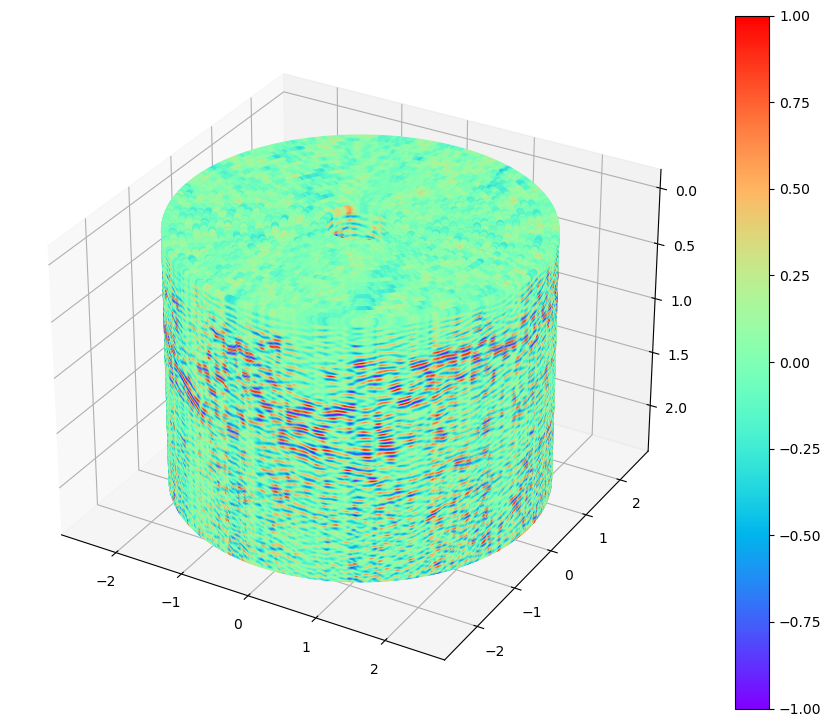

In [15]:
fig = plt.figure(figsize=(11,9), dpi=100)
ax = plt.subplot(111, projection='3d')

cmap = plt.cm.rainbow
plot = ax.scatter3D(x_arr, y_arr, z_arr, c=c_arr, cmap=cmap)
ax.invert_zaxis()
fig.colorbar(plot)
plt.show()

### Slicing through the cube to get the depth slices

In [15]:
def depthSlice_arr(x_main, y_main, z_main, c_main, depth):
    mask = (z_main >= depth) & (z_main <depth+.01)
    x =x_main[mask]
    y =y_main[mask]
    z =z_main[mask]
    c =c_main[mask]
    
    return x, y, z, c

#### Slicing through 25 cm depth

In [16]:
xx, yy, _, cc = depthSlice_arr(x_arr, y_arr, z_arr, c_arr, depth=.25)

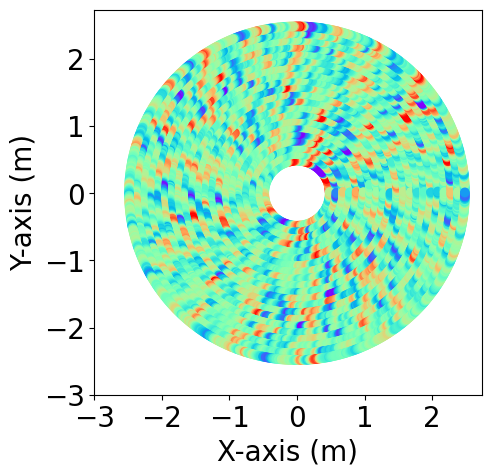

In [19]:
plt.figure(figsize=(5, 5))
cmap = plt.cm.rainbow
plot_2d = plt.scatter(xx, yy, c=cc, cmap=cmap)
plt.xlabel('X-axis (m)',size=20)
plt.ylabel('Y-axis (m)',size=20)
lab = np.arange(-3, 3)
plt.xticks(lab, fontsize=20)
plt.yticks(lab, fontsize=20);
#fig.colorbar(plot_2d)

### Interpolating the points for better visualization

In [20]:
def interpolator(data_3d, num_grid=200, grid_ext=3):
    '''
    Interpolate the Scatter Plots.
    
    Param
    -----
    data_3d: contains the x, y, and amplitude values.
    '''

    # Will change the dimension when necessary
    int_mesh = np.mgrid[-1*grid_ext:grid_ext:num_grid*1j, -1*grid_ext:grid_ext:num_grid*1j]
    mesh = int_mesh.reshape(2,-1).T

    # perform the interpolation
    points = np.column_stack((data_3d[0], data_3d[1]))
    # print(x, y, points)
    new_vals = RBFInterpolator(points, data_3d[2])(mesh)
    interp_values = new_vals.reshape(num_grid, num_grid)
    
    return int_mesh, interp_values

The function above requires `x, y` and `c` to be in a list

In [21]:
data_xyc = [xx, yy, cc]

In [22]:
num_grid_value = 300 # The smaller the smoothier
grid_ext_val = 3
int_mesh_25cm, ampl_25cm = interpolator(data_xyc, num_grid= num_grid_value,\
                                        grid_ext= grid_ext_val)

In [23]:
def plot_interpolated(int_mesh, ampl, norm_val = 1, inner_rad=0.54, outer_rad=2.54, val=5):
    
    # For creating the small radius
    theta = np.linspace(0, 2 * np.pi, 150)
    x_inner = inner_rad * np.cos( theta )
    y_inner = inner_rad * np.sin( theta )
    
    # used for heightening the value of the roots.
    norm = PowerNorm(gamma=norm_val)
    
    # extracting the x_data and y_data
    x_data, y_data = int_mesh[0], int_mesh[1]
    
    # Create a mask for points outside the circle
    # Circle center and radius
    center_x, center_y = 0, 0
    radius = outer_rad

    mask = (x_data - center_x)**2 + (y_data - center_y)**2 > radius**2
    ampl[mask] = np.nan


    # Create the figure and axis
    fig, ax = plt.subplots()

    # Display the pcolormesh inside the circle
    c = ax.pcolormesh(x_data, y_data, ampl, cmap=cmap, norm=norm)
    ax.fill_between(x_inner, y_inner, color='white')
    ax.set_title(f'Depth Slice = {val} cm',size=20)
    ax.set_xlabel('X-axis (meters)',size=20)
    ax.set_ylabel('Y-axis (meters)',size=20)
    
    lab = np.arange(-4, 4)
    ax.set_xticklabels(lab, fontsize=20)
    ax.set_yticklabels(lab, fontsize=20)
    

    # Set aspect ratio to equal
    ax.set_aspect('equal', adjustable='box')
    fig.colorbar(c)
    
    # Display the plot
    plt.show()

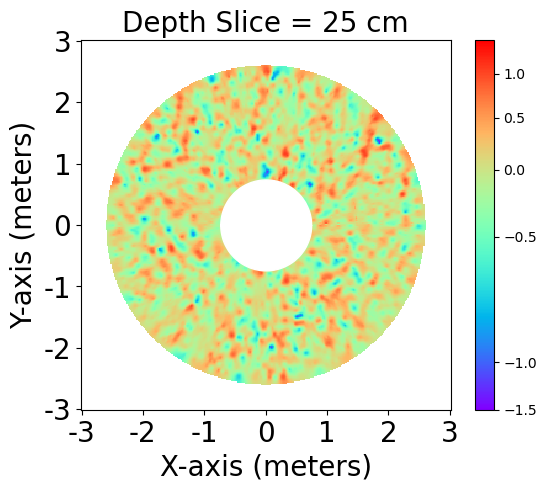

In [28]:
plot_interpolated(int_mesh_25cm, ampl_25cm , norm_val = .7, inner_rad=0.54, outer_rad=2.6, val=25)

### SEE THE INDIVIDUAL PROCESSED TREE NOTEBOOK FOR THE VISUALIZATION OF THE DIFFERENT DEPTH SLICE